# Brain Cancer MRI Images Classification

Cancer is the second leading cause of death after cardiovascular diseases. Out of all types of cancer, brain cancer has the lowest survival rate. Brain tumors can have different types depending on several factors such as the shape, texture, and location of the tumor (e.g., Acoustic Neuroma, Meningioma, Pituitary, Glioma, CNS Lymphoma . . . etc). In clinical practice, the incident rates of Glioma, Meningioma, and Pituitary tumors are approximately 45%, 15%, and 15%, respectively, among all brain tumors. Proper diagnosis of the tumor type enables the doctor to make the correct treatment choice and help save the patient’s life.


Currently, anomaly detection through MRI is manual mostly and clinicians have to spend a lot of time to detect and segment the tumor for treatment and surgical purpose. This manual technique is also prone to errors and can compromise life. Also, diversity of Tumor types, makes the detection more difficult due to the complex structure of the brain. In order to resolve these issues, studies have started to focus on various machine learning and Deep Learning techniques for computer-based tumor detection and segmentation.


 [This paper](https://www.sciencedirect.com/science/article/abs/pii/S0895611121000896?via%3Dihub) reviews different papers that tried to do the task of brain cancer MRI image classification. In this homework, we will implement and compare some of these methods.

First, import all the libraries you may need here:

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import h5py
from PIL import Image
import os
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import Model, layers

## 1. Load Data (5 pt)

We have a dataset of 3064 T1-weighted contrast-enhanced MRI images of 3 brain tumor types (Meningiomas, Gliomas, and Pituitary tumors). You are supposed to download and unzip the [data](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5).

We suggest loading all of the data in one folder in google drive.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!mkdir bioAdvHW3
%cd bioAdvHW3
!mkdir brainTumor
!wget -O 5.1 https://figshare.com/ndownloader/articles/1512427/versions/5
!unzip 5.1

!unzip brainTumorDataPublic_1-766.zip -d brainTumor
!unzip brainTumorDataPublic_1533-2298.zip -d brainTumor
!unzip brainTumorDataPublic_2299-3064.zip -d brainTumor
!unzip brainTumorDataPublic_767-1532.zip -d  brainTumor

/kaggle/working/bioAdvHW3
--2022-12-07 17:25:31--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 34.240.56.236, 52.19.91.26, 2a05:d018:1f4:d000:e935:bbdf:68e6:9a6a, ...
Connecting to figshare.com (figshare.com)|34.240.56.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5.1’

5.1                 100%[===================>] 838.76M  21.1MB/s    in 42s     

2022-12-07 17:26:15 (19.9 MB/s) - ‘5.1’ saved [879501695/879501695]

Archive:  5.1
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              
Archive:  brainTumorDataPublic_1-766.zip
  inflating: brainTumor/1.mat        
  inflating: brainTumor/10.mat       
  inflating: brainTumor/100.mat      
  

## 2. Visualize some Images (7 pt)

In this part, we want to show 2 random MRI images from each category in the dataset. As we have 3 types of tumors, we should have 6 images in the output.

In this dataset, the images are in matlab format and each image is stored as a struct that includes tumorMask, tumorBorder, image, PID (PatientID), label. The h5py library is used to read the photos in the code section. Using this library, we read the dataset images that are in mat format.

 Images are labeled this way in .mat files:

Label 1: meningioma

Label 2: glioma

Label 3: pituitary

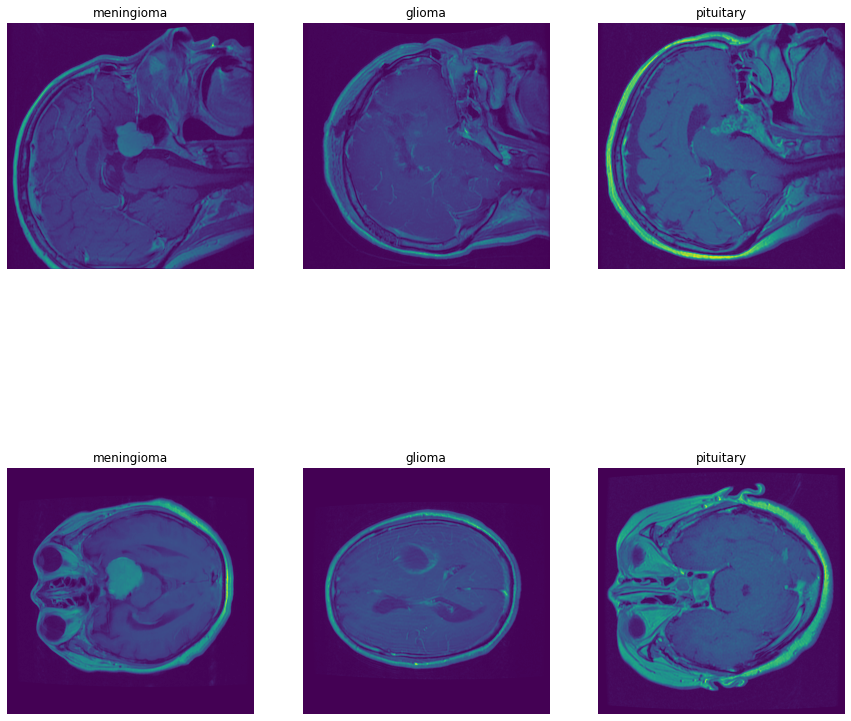

In [4]:
import random
from PIL import Image

to_name={0:"meningioma", 1: "glioma", 2: "pituitary"}
fig, axs = plt.subplots(2, 3, figsize=(15,15))
cnt=[0,0,0]
 
l=list(range(1, 3065))
random.shuffle(l)
for i in l:
    f = h5py.File(f'brainTumor/{i}.mat','r')
    # print(f.get("cjdata").keys())
    label=int(f.get("cjdata/label")[0])-1
    if cnt[label]>=2:
        continue
    axs[cnt[label], label].imshow(np.array(f.get("cjdata/image")))
    axs[cnt[label], label].axis('off')
    axs[cnt[label], label].set_title(to_name[label])
    cnt[label]+=1

plt.show()
# In MATLAB cjdata = 
# struct with fields:
#   label
#   PID
#   image
#   tumorBorder
#   tumorMask

## Split images to validation and train (10 pt)

Now, we want to save images in 3 different folders. Each folder should contain MRI images of one tumor type.

Then you should split data to train and validation. 80% of the data should be train and the rest should be validation.


In [5]:
import shutil
import os 
from PIL import Image
import tqdm

!mkdir  brainTumor/1
!mkdir  brainTumor/2
!mkdir  brainTumor/3

for i in tqdm.tqdm(range(1, 3065)):
    f = h5py.File(f'brainTumor/{i}.mat','r')
    label=int(f.get("cjdata/label")[0])
    cv2.imwrite(f'brainTumor/{label}/{i}.png', np.array(f.get("cjdata/image")).astype("uint16"))


for label in range(1,4):
    samples=os.listdir(f'brainTumor/{label}')
    random.shuffle(samples)
    os.makedirs(f'brainTumor/train/{label}', exist_ok=True)
    os.makedirs(f'brainTumor/val/{label}', exist_ok=True)
    for i in range(int(len(samples)*0.8)):
        shutil.move(f'brainTumor/{label}/{samples[i]}', f'brainTumor/train/{label}/{samples[i]}')  
    for i in range(int(len(samples)*0.8), len(samples)):
        shutil.move(f'brainTumor/{label}/{samples[i]}', f'brainTumor/val/{label}/{samples[i]}')  

100%|██████████| 3064/3064 [00:40<00:00, 76.02it/s]


### Data Preprocessing (15 pt)

Medical images datasets are smaller in size than the datasets available in other domains due to their limitations. One way to overcome the problem of lack of sufficient amount of training data is data augmentation.

There are many type of manipulations that we can use for this target. Here are a list of some augmentation techniques that you can use in this task:

Horizontal and vertical flips(OK)

Rotation(OK)

Zooming(OK)

Shifting(OK)

Brightness (OK)

ZCA whitening (OK)

Shearing



In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = "brainTumor/train"
val_dir =  "brainTumor/val"
train_data = ImageDataGenerator(rotation_range=10, # rotation
                                width_shift_range=0.2, # horizontal shift
                                height_shift_range=0.2, # vertical shift
                                zoom_range=0.2, # zoom
                                horizontal_flip=True, # horizontal flip
                                vertical_flip=True,
                                shear_range=0.2, 
                                brightness_range=[0.2,1.2],
                                zca_whitening=True) #complete this function for augmentation perpose
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator()
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2450 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


In [7]:
for (trainX, trainY) in traindata:
    print(trainX.min(), trainX.max(), trainX.mean(), trainX.shape)
    break

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


0.0 255.0 92.14244 (32, 224, 224, 3)


## Implementing 3 Different Classification Models

Now we want to design models for MRI image classification. Models that we want to use are these:

1- ResNet50

2- AlexNet

3- Multi-layer perceptron

### ResNet Model Design, image level (20pt)

Now it's time to create the model. Here we use Residual Network architecture composed of 50 layers for our model. Set the optimizer to 'Adam' and learning rate to '0.0003' for 200 epoches. You can change settings like LR untill getting better performance.


In this task we consentrate on the content of [this paper](https://doi.org/10.1016/j.artmed.2019.101779).

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from  tensorflow.keras.optimizers import Adam

#Complete your code here...
ResNet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
ResNet_model.add(tf.keras.layers.BatchNormalization(input_shape=(224,224,3)))
ResNet_model.add(pretrained_model)
ResNet_model.add(Flatten())
ResNet_model.add(Dense(3, activation='softmax'))

2022-12-07 17:27:20.933568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 17:27:21.038431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 17:27:21.039317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 17:27:21.041611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [9]:
ResNet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,871
Trainable params: 23,540,745
Non-trainable params: 53,126
_________________________________________________________________


### Train the ResNet50 model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.


In [10]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

ResNet_model.compile(optimizer=Adam(lr=0.0003),loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1])

history = ResNet_model.fit(traindata, validation_data=valdata, epochs=200)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-12-07 17:27:27.291257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-12-07 17:27:34.442291: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


77/77 [==============================] - 68s 718ms/step - loss: 0.6316 - accuracy: 0.7404 - precision: 0.7739 - recall: 0.7012 - get_f1: 0.7339 - val_loss: 0.9500 - val_accuracy: 0.5505 - val_precision: 0.6082 - val_recall: 0.4121 - val_get_f1: 0.4789
Epoch 2/200
77/77 [==============================] - 54s 695ms/step - loss: 0.3884 - accuracy: 0.8457 - precision: 0.8637 - recall: 0.8200 - get_f1: 0.8417 - val_loss: 1.2100 - val_accuracy: 0.3094 - val_precision: 0.3420 - val_recall: 0.3013 - val_get_f1: 0.3149
Epoch 3/200
77/77 [==============================] - 54s 697ms/step - loss: 0.3539 - accuracy: 0.8518 - precision: 0.8709 - recall: 0.8343 - get_f1: 0.8516 - val_loss: 0.9587 - val_accuracy: 0.5342 - val_precision: 0.6444 - val_recall: 0.2508 - val_get_f1: 0.3524
Epoch 4/200
77/77 [==============================] - 54s 696ms/step - loss: 0.3467 - accuracy: 0.8539 - precision: 0.8706 - recall: 0.8404 - get_f1: 0.8546 - val_loss: 0.8526 - val_accuracy: 0.6010 - val_precision: 0.678

### Loss and accuracy diagrams for ResNet50 (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.

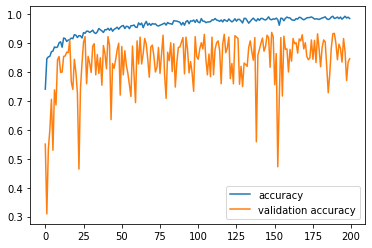

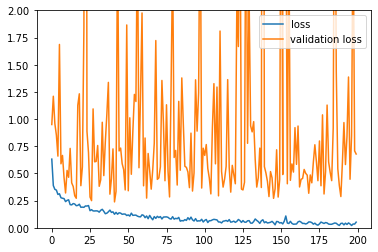

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()
plt.ylim(0,2)
plt.show()

We could see, training accuracy and loss improves over training consistently, however, the validation-set situation is different and after a few epochs it reaches its peak and then it only goes up and down without any meaningful trend. At the end of training the results of validation are val_loss: 0.6786 - val_accuracy: 0.8453 - val_precision: 0.8480 - val_recall: 0.8453 - val_get_f1: 0.8529 which is significantly lower than training set results which are as follows: loss: 0.0521 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - get_f1: 0.9843

### ResNet Model, Patient level (30 pt)


Here we want to repeat ResNet model in a different way. You should do all the steps again with a difference in spliting the data. In patient level you should pay attention that all the images from a patient should be either in train or validation.

So, do the spliting part of data with considering this point and then do all the steps again (design the model, train the model, plot accuracy and loss diagrams).


How different are the results?

Which method do yo think is better? Which results are more reliable? Image level method or patient level method?

In [12]:
def getstrPID(PID):
    strPID=""
    for j in range(len(PID)):
        strPID+=str(PID[j])[1:-1]
    return strPID

all_patient=[]
for i in tqdm.tqdm(range(1, 3065)):
    f = h5py.File(f'brainTumor/{i}.mat','r')
    # print(f.get("cjdata").keys())
    PID=getstrPID(f.get("cjdata/PID"))
    all_patient.append(PID)

all_patient=list(set(all_patient))
print(f"len all patient:{len(all_patient)}")
random.shuffle(all_patient)
is_train={}
for patient in all_patient[:int(len(all_patient)*0.8)]:
    is_train[patient]=1
for patient in all_patient[int(len(all_patient)*0.8):]:
    is_train[patient]=0

for label in range(1,4):
    os.makedirs(f'brainTumor/train-pa/{label}', exist_ok=True)
    os.makedirs(f'brainTumor/val-pa/{label}', exist_ok=True)

for i in tqdm.tqdm(range(1, 3065)):
    f = h5py.File(f'brainTumor/{i}.mat','r')
    
    label=int(f.get("cjdata/label")[0])
    PID=getstrPID(f.get("cjdata/PID"))
    cv2.imwrite(f'brainTumor/{"train-pa" if is_train[PID] else "val-pa"}/{label}/{i}.png', np.array(f.get("cjdata/image")).astype("uint16"))

!rm brainTumor/*.mat

100%|██████████| 3064/3064 [00:02<00:00, 1236.43it/s]


len all patient:233


100%|██████████| 3064/3064 [00:41<00:00, 73.55it/s]


In [13]:
train_dir = "brainTumor/train-pa"
val_dir =  "brainTumor/val-pa"
train_data = ImageDataGenerator(rotation_range=10, # rotation
                                width_shift_range=0.2, # horizontal shift
                                height_shift_range=0.2, # vertical shift
                                zoom_range=0.2, # zoom
                                horizontal_flip=True, # horizontal flip
                                vertical_flip=True,
                                shear_range=0.2,
                                brightness_range=[0.2,1.2],
                                zca_whitening=True) #complete this function for augmentation perpose
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator()
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

Found 2511 images belonging to 3 classes.
Found 553 images belonging to 3 classes.


In [14]:
ResNet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=5,
                   weights='imagenet')

ResNet_model.add(tf.keras.layers.BatchNormalization(input_shape=(224,224,3)))
ResNet_model.add(pretrained_model)
ResNet_model.add(Flatten())
ResNet_model.add(Dense(3, activation='softmax'))
ResNet_model.summary()

ResNet_model.compile(optimizer=Adam(lr=0.0003),loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1])
history = ResNet_model.fit(traindata, validation_data=valdata, epochs=200)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 23,593,871
Trainable params: 23,540,745
Non-trainable params: 53,126
_________________________________________________________________
Epoch 1/200
79/79 [==============================] - 62s 715ms/step - loss: 0.6553 - accuracy: 0.7391 - precision_1: 0.7684 - recall_1: 0.7097 - get_f1: 0.7350 - val_loss: 1.0742 - val_accuracy: 0.4846 - val_precision_1: 0.4830 - val_r

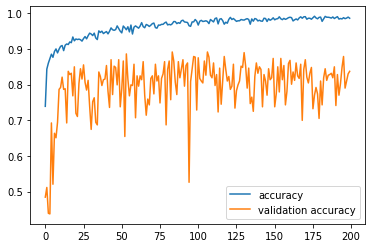

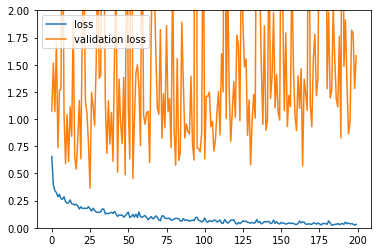

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.ylim(0,2)
plt.legend()
plt.show()

How different are the results?accuracy drops by couple of percentage loss goes up compared to previous run. in contrast to previous results, the results get worse after cuple of epochs suggesting an over fit. Which method do you think is better? Which results are more reliable? Image level method or patient level method?The patient level method is more reliable because the model may learn some things from patients in the train set and in the validation phase model recognize the patients and assigns the correct label with that knowledge. So when we deploy the model in the real world because all patients are new the performance of model drops. 

## 1. AlexNet Model Design (20 pt)

Now we want to test another model. We will use AlexNet here.

Run it for 100 epoches. You can change settings to get better performance.

set optimizer = 'Adam' and loss = 'categorical_crossentropy'.



In [16]:
AlexNet_model = keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(224,224,3)),
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

In [17]:
AlexNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_3 (Batch (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)      

### Train the AlexNet model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.

In [18]:
AlexNet_model.compile(optimizer=Adam(lr=0.0003),loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1])
history = AlexNet_model.fit(traindata, validation_data=valdata, epochs=100)

Epoch 1/100
79/79 [==============================] - 53s 650ms/step - loss: 3.5821 - accuracy: 0.4209 - precision_2: 0.4256 - recall_2: 0.4022 - get_f1: 0.4144 - val_loss: 3.4850 - val_accuracy: 0.4503 - val_precision_2: 0.4501 - val_recall_2: 0.4485 - val_get_f1: 0.4447
Epoch 2/100
79/79 [==============================] - 52s 660ms/step - loss: 1.4488 - accuracy: 0.4871 - precision_2: 0.5020 - recall_2: 0.4532 - get_f1: 0.4766 - val_loss: 1.5125 - val_accuracy: 0.4629 - val_precision_2: 0.4610 - val_recall_2: 0.4593 - val_get_f1: 0.4638
Epoch 3/100
79/79 [==============================] - 51s 646ms/step - loss: 1.1944 - accuracy: 0.5062 - precision_2: 0.5238 - recall_2: 0.4564 - get_f1: 0.4861 - val_loss: 0.7491 - val_accuracy: 0.6564 - val_precision_2: 0.6858 - val_recall_2: 0.6275 - val_get_f1: 0.6571
Epoch 4/100
79/79 [==============================] - 52s 655ms/step - loss: 1.1186 - accuracy: 0.5185 - precision_2: 0.5482 - recall_2: 0.4576 - get_f1: 0.4985 - val_loss: 0.7690 - val

### Loss and accuracy diagrams for AlexNet (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.

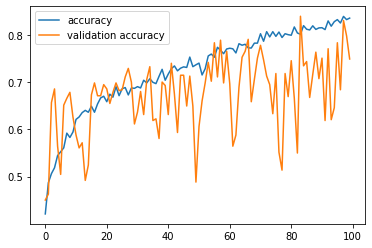

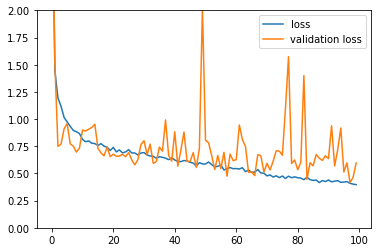

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()
plt.ylim(0,2)
plt.show()

accuracy and loss for both training set and validation set improves troughout the training. which means larger learning rate could leads to better results. 

##Design the Multi-Layer Perceptron model (20 pt)

We want to implement a Multi layer perceptron deep network to classify our dataset too.

Do the steps as you did in other models.

In [20]:
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(128,128))
val_data = ImageDataGenerator()
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(128,128))

Found 2511 images belonging to 3 classes.
Found 553 images belonging to 3 classes.


In [21]:
image_size = 128
batch_size = 32

MLP_model = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=(128,128,3)),
    keras.layers.Flatten(input_shape=(128,128,3)),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

In [22]:
MLP_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
flatten_3 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              50332672  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)              

### Train the model (10pt)

In [23]:
MLP_model.compile(optimizer=Adam(lr=0.0003),loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1])
history = MLP_model.fit(traindata, validation_data=valdata, epochs=100)

Epoch 1/100
79/79 [==============================] - 33s 405ms/step - loss: 14.3556 - accuracy: 0.3576 - precision_3: 0.3584 - recall_3: 0.3568 - get_f1: 0.3575 - val_loss: 1.8246 - val_accuracy: 0.5280 - val_precision_3: 0.5301 - val_recall_3: 0.5262 - val_get_f1: 0.5335
Epoch 2/100
79/79 [==============================] - 33s 410ms/step - loss: 6.9626 - accuracy: 0.3895 - precision_3: 0.3907 - recall_3: 0.3871 - get_f1: 0.3899 - val_loss: 0.9929 - val_accuracy: 0.5660 - val_precision_3: 0.6775 - val_recall_3: 0.4521 - val_get_f1: 0.5465
Epoch 3/100
79/79 [==============================] - 33s 412ms/step - loss: 4.6144 - accuracy: 0.3759 - precision_3: 0.3776 - recall_3: 0.3684 - get_f1: 0.3711 - val_loss: 1.0709 - val_accuracy: 0.3653 - val_precision_3: 0.4079 - val_recall_3: 0.1121 - val_get_f1: 0.1740
Epoch 4/100
79/79 [==============================] - 33s 416ms/step - loss: 3.1201 - accuracy: 0.3744 - precision_3: 0.3751 - recall_3: 0.3544 - get_f1: 0.3648 - val_loss: 1.0192 - va

### Loss and accuracy diagrams for multi-layer perceptron (10 pt)


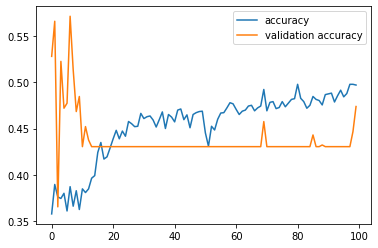

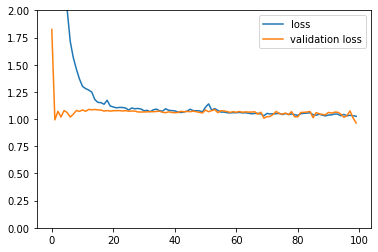

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()
plt.ylim(0,2)
plt.show()

we could see that the model couldn't learn anything. There could be two reasons
1) The model should learn features from different parts of images separately because we do not use convolutions which generalize features from one part of image to another parts. 
This drawback gets more important when considering the small size of the training set. 
2) The model is too simple and small to handle the complexity of our dataset. 

#### Now answer these questions:

1- How close are your answers to those in the paper?
خیر نتایج مقاله بهتر است. 99% در مقایسه با 92% که کمتر است.


2- Why do you think they aren't close if they aren't?
Tensorflow dataloader load png images with 256 gray scale which lost information. That information may helps our model to get higher accuracy. 

3- What suggestions do you have for improving any of these methods?
for alexnet a larger learning rate will probably helps. 

4- Compare the results from these 3 models. How would you rate each method in terms of its effectiveness?
all three methods are fast in evaluation time which make them reseanable for deployment. 
although alexnet is smaller (and faster) but it gets lower accuracy compared to resnet; therefore resnet is the best option.

5- Can we trust our answer for any MRI image of a patient? Answer the question in detail.
خیر نمیتوانیم به پاسخمان اعتماد کنیم به چند دلیل
1) مدل به دقت 90 درصد میرسد یعنی در حالتی که هیچ مشکل خاصی پیش نیاید برای 10 درصد بیماران اشتباه تشخیص میدهد.
2) ما برسی نکردیم که مدل چه چیزی یاد گرفته است و به همین دلیل نمیتوانیم مطمئن باشیم که مدل چیز معنی‌داری را یادگرفته است. 
3) برای یک بیمار خاص با توجه به این که مطمئن نیستیم مدل چه چیزی یادگرفته است برای توجیه پیشبینی خود هیچ توضیحی نداریم
4) ممکن است در دیتاست بایاس مثلا روی نژاد وجود داشته باشد و گروه‌های اقلیت در آن دیده نشده باشند. مثلا ممکن است هیچ بیمار هندی‌ای در آن وجود نداشته باشد و به همین دلیل اگر بیماری هندی برای تشخیص بیماری به این سیستم مراجعه کند خروجی ممکن است اشتباه باشد حتی با درصد بالای 10% که مدل ادعا میکند دقت دارد. 
